In [1]:
%matplotlib inline
from pylab import *
import cv2

In [2]:
rcParams['figure.figsize'] = 10, 10

In [3]:
def load_image(path):
    img = cv2.imread(str(path))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [4]:
import torch

In [5]:
from torch.autograd import Variable

def cuda(x):
    return x.cuda(async=True) if torch.cuda.is_available() else x
def variable(x, volatile=False):
    if isinstance(x, (list, tuple)):
        return [variable(y, volatile=volatile) for y in x]
    return cuda(Variable(x, volatile=volatile))

In [6]:
from models import UNet16, LinkNet34, UNet11, UNet, D_LinkNet34
def get_model(model_path, model_type='unet11', problem_type='binary'):
    """

    :param model_path:
    :param model_type: 'UNet', 'UNet16', 'UNet11', 'LinkNet34'
    :param problem_type: 'binary', 'parts', 'instruments'
    :return:
    """
    if problem_type == 'binary':
        num_classes = 1
    elif problem_type == 'parts':
        num_classes = 4
    elif problem_type == 'instruments':
        num_classes = 8

    if model_type == 'UNet16':
        model = UNet16(num_classes=num_classes)
    elif model_type == 'UNet11':
        model = UNet11(num_classes=num_classes)
    elif model_type == 'LinkNet34':
        model = LinkNet34(num_classes=num_classes)
    elif model_type == 'UNet':
        model = UNet(num_classes=num_classes)
    elif model_type == 'DLinkNet':
        model = D_LinkNet34(num_classes=num_classes, pretrained=True)

    state = torch.load(str(model_path))
    state = {key.replace('module.', ''): value for key, value in state['model'].items()}
    model.load_state_dict(state)

    if torch.cuda.is_available():
        return model.cuda()

    model.eval()

    return model

In [7]:
from torchvision.transforms import ToTensor, Normalize, Compose

In [8]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
def mask_overlay(image, mask, color=(0, 255, 0)):
    """
    Helper function to visualize mask on the top of the car
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]    
    return img

In [10]:
model_path = r'D:\repos\study\robot-surgery-segmentation\runs\debug\gpu\model_0.pt'
model = get_model(model_path, model_type='DLinkNet', problem_type='binary')

In [11]:
img_file_name = r'D:\development\concept_development\Road_Detection\dataset\codalab_dataset\val\images\157050.jpg'
gt_file_name = 'data/cropped_train/instrument_dataset_3/binary_masks/frame004.png'

In [12]:
img = load_image(img_file_name)
# gt = cv2.imread(gt_file_name, 0) > 0

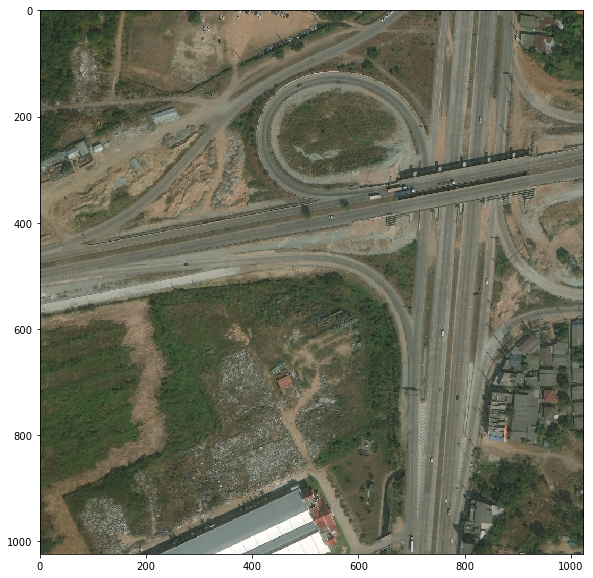

In [13]:
imshow(img)

In [14]:
img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
input_img = torch.unsqueeze(variable(img_transform(img), volatile=True), dim=0)

C:\Users\panchani\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [16]:
mask = model(input_img)

In [17]:
mask_array = mask.data[0].cpu().numpy()[0]

In [18]:
from torch.nn import functional as F
mask_sigmoid = F.sigmoid(mask).data[0].cpu().numpy()[0]

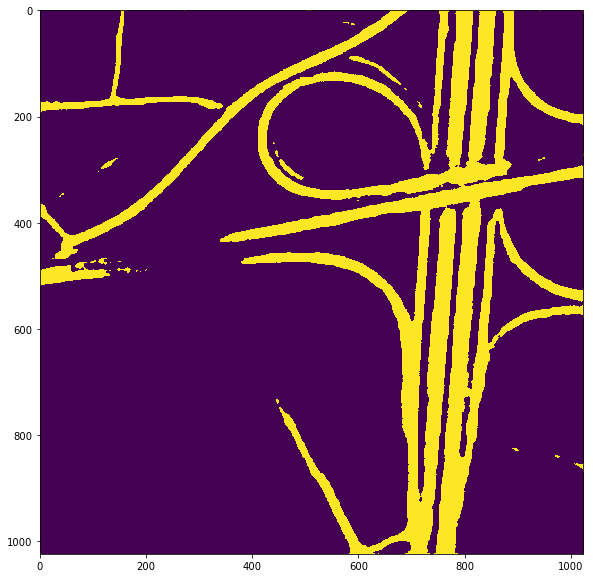

In [20]:
imshow(mask_sigmoid > 0.1)

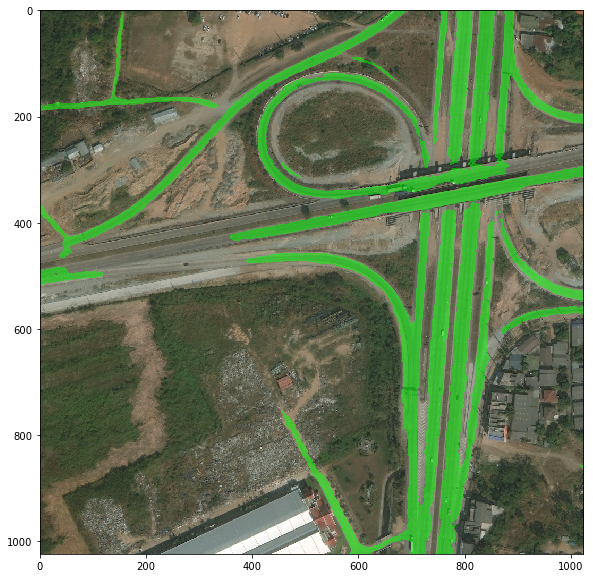

In [21]:
imshow(mask_overlay(img, (mask_array > 0).astype(np.uint8)))